In [1]:
import sys
sys.path.append('../src')

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import deepcopy
from pathlib import Path
from run_gsat import GSAT, ExtractorMLP
from run_re_gsat import ReGSAT
from utils import get_data_loaders, get_model, set_seed, init_metric_dict, get_local_config_name, Writer
from trainer import get_viz_idx, visualize_results, train_model, plot_metrics
from datetime import datetime
import yaml
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

## Setup

In [2]:
# dataset_name = 'ba_2motifs'
# dataset_name = 'mutag'
dataset_name = 'spmotif_0.5'
model_name = 'GIN'

# dataset_name = 'ogbg_molhiv'
# model_name = 'PNA'

method_name = 'GSAT'
cuda_id = 0
seed = 0
set_seed(seed)

In [3]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

if model_name == 'GIN':
    model_config = {'model_name': 'GIN', 'hidden_size': 64, 'n_layers': 2, 'dropout_p': 0.3, 'use_edge_attr': True}
else:
    assert model_name == 'PNA'
    model_config = {'model_name': 'PNA', 'hidden_size': 80, 'n_layers': 4, 'dropout_p': 0.3, 'use_edge_attr': False, 
                    'atom_encoder': True, 'aggregators': ['mean', 'min', 'max', 'std'], 'scalers': False}
    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (datetime.now().strftime("%m_%d_%Y-%H_%M_%S") + '-' + dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)

In [4]:
loaders, test_set, x_dim, edge_attr_dim, num_class, aux_info = get_data_loaders(data_dir, dataset_name, batch_size=128, random_state=seed,
                                                                                splits={'train': 0.8, 'valid': 0.1, 'test': 0.1}, 
                                                                                mutag_x=True if dataset_name == 'mutag' else False)
model_config['deg'] = aux_info['deg']

[INFO] Using default splits!
[INFO] Calculating degree...


In [5]:
config_dir = Path('../src/configs')
global_config = yaml.safe_load((config_dir / 'global_config.yml').open('r'))
local_config_name = get_local_config_name(model_name, dataset_name)
local_config = yaml.safe_load((config_dir / local_config_name).open('r'))

model_config = local_config['model_config']
data_config = local_config['data_config']
method_config = local_config[f'{method_name}_config']
shared_config = local_config['shared_config']
assert model_config['model_name'] == model_name
assert method_config['method_name'] == method_name

lr, wd = method_config['lr'], method_config.get('weight_decay', 0)
scheduler_config = method_config.get('scheduler', {})
log_dir = "./logs"
writer = Writer(log_dir=log_dir)

## GSAT

[INFO] Using multi_label: False


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [13:25<00:00,  8.06s/it]


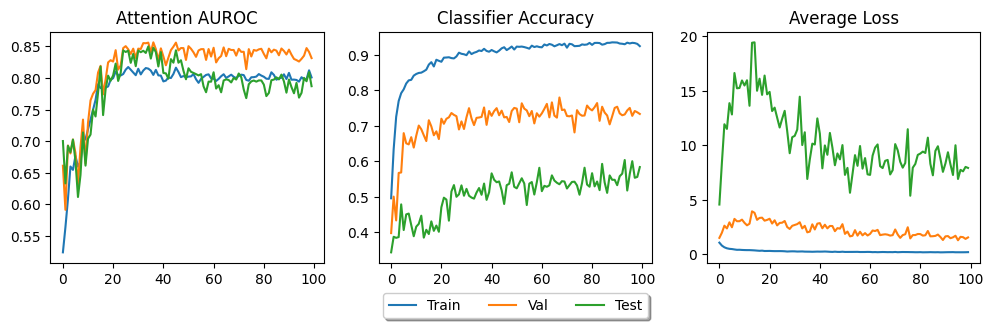

In [10]:
model = get_model(x_dim, edge_attr_dim, num_class, aux_info['multi_label'], model_config, device)
extractor = ExtractorMLP(model_config['hidden_size'], shared_config).to(device)
optimizer = torch.optim.Adam(list(extractor.parameters()) + list(model.parameters()), lr=lr, weight_decay=wd)
scheduler = None if scheduler_config == {} else ReduceLROnPlateau(optimizer, mode='max', **scheduler_config)

gsat = GSAT(model, extractor, optimizer, scheduler, writer, 
            device, log_dir, dataset_name, num_class, 
            aux_info['multi_label'], seed, method_config, shared_config)
metrics_gsat = train_model(model_config, method_config, gsat, loaders)
plot_metrics(metrics_gsat)

In [11]:
print("Test att_auroc with GSAT: ", metrics_gsat["test"]["att_auroc"][-1])
print("Test clf_acc with GSAT: ", metrics_gsat["test"]["clf_acc"][-1])

Test att_auroc with GSAT:  0.7869811327672965
Test clf_acc with GSAT:  0.5835


## ReGSAT

[INFO] Using multi_label: False


100%|██████████| 100/100 [14:22<00:00,  8.63s/it]


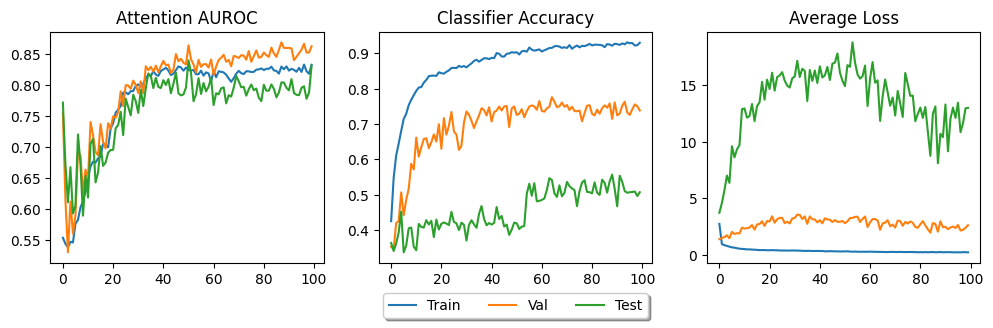

In [6]:
resilient_config = {
    'dual_lr': 10.0,
    'resilient_alpha': 2.0,
    'prox_loss_tol': 0.01,
    'info_loss_tol': 0.2,
    'prox_loss_multiplier_init': 1.0,
    # 'pred_loss_coef': 1.0,
    # 'info_loss_coef': 1.0,
}

method_config_re_gsat = {**method_config, **resilient_config}
method_config_re_gsat["epochs"] = 100

model = get_model(x_dim, edge_attr_dim, num_class, aux_info['multi_label'], model_config, device)
extractor = ExtractorMLP(model_config['hidden_size'], shared_config).to(device)
optimizer = torch.optim.Adam(list(extractor.parameters()) + list(model.parameters()), lr=lr, weight_decay=wd)
scheduler = None if scheduler_config == {} else ReduceLROnPlateau(optimizer, mode='max', **scheduler_config)

regsat = ReGSAT(model, extractor, optimizer, scheduler, writer, 
            device, log_dir, dataset_name, num_class, 
            aux_info['multi_label'], seed, method_config_re_gsat, shared_config)

metrics_re_gsat = train_model(model_config, method_config_re_gsat, regsat, loaders)
plot_metrics(metrics_re_gsat)

In [8]:
print("Test att_auroc with ReGSAT: ", metrics_re_gsat["test"]["att_auroc"][-1])
print("Test clf_acc with ReGSAT: ", metrics_re_gsat["test"]["clf_acc"][-1])

Test att_auroc with ReGSAT:  0.8315136887869278
Test clf_acc with ReGSAT:  0.5075


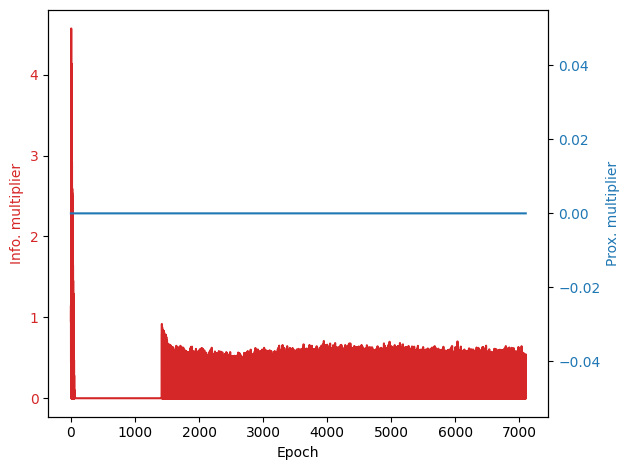

In [12]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Info. multiplier', color=color)
ax1.plot(regsat.multiplier_history["info"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Prox. multiplier', color=color)
ax2.plot(regsat.multiplier_history["prox"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## Old code (not used for now)

100%|██████████| 10/10 [00:00<00:00, 12.06it/s]


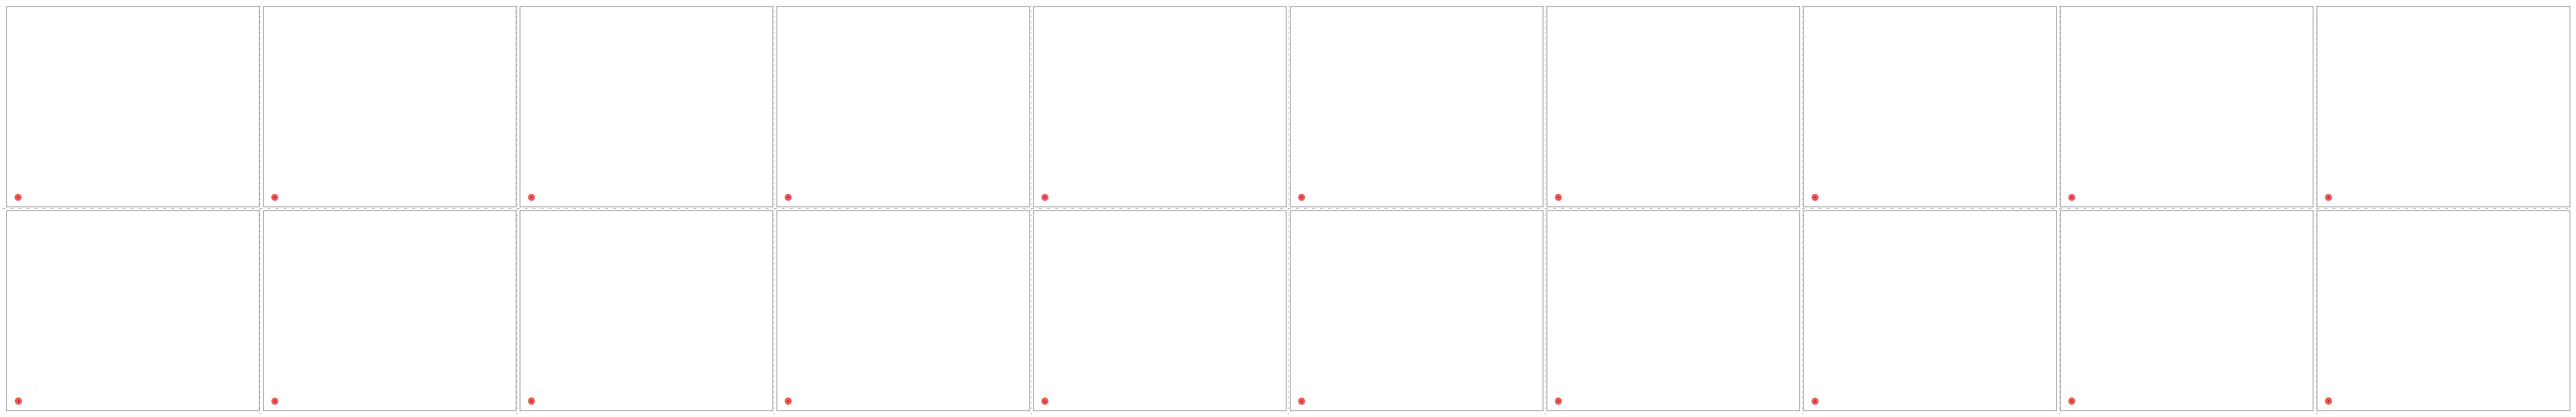

In [39]:
num_viz_samples = 10
assert aux_info['multi_label'] is False

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)
visualize_results(gsat, all_viz_set, test_set, num_viz_samples, dataset_name, model_config.get('use_edge_attr', False))

100%|██████████| 10/10 [00:00<00:00, 13.55it/s]


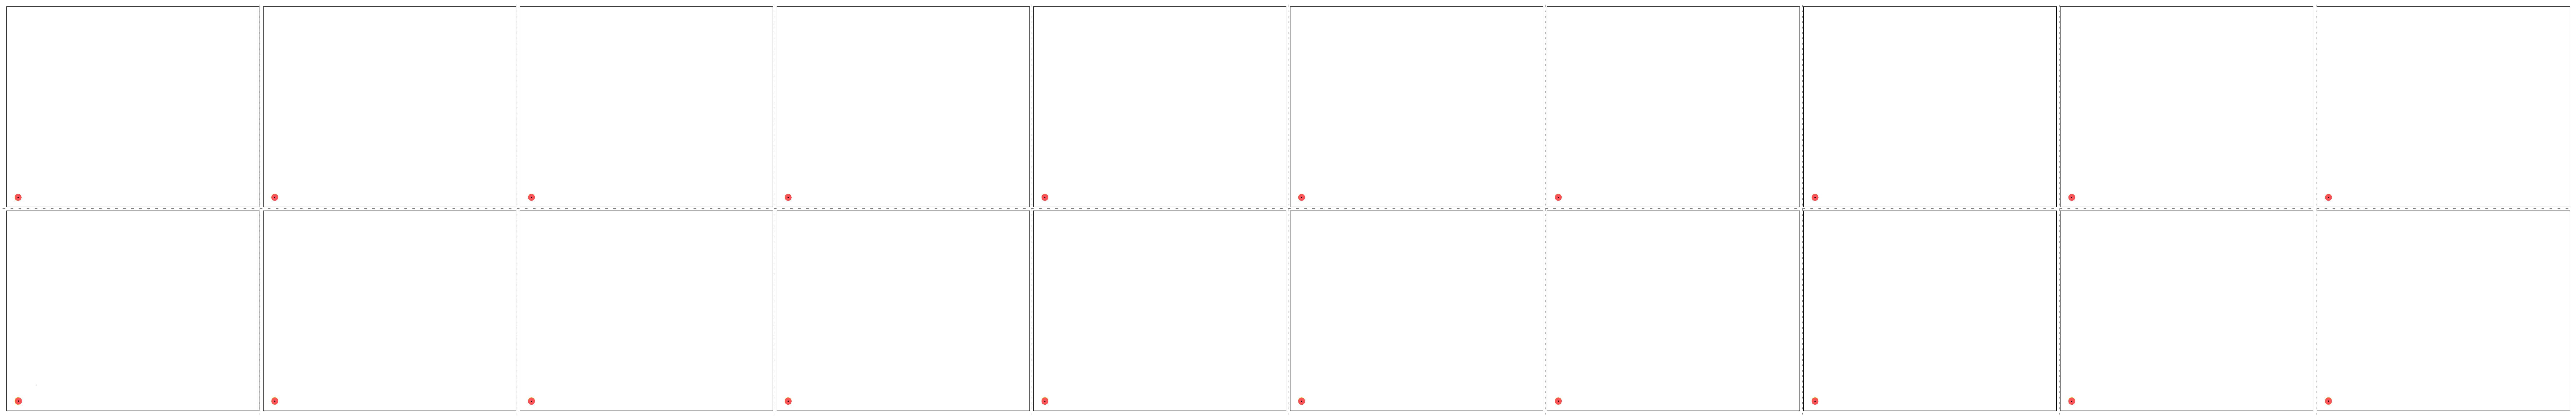

In [37]:
num_viz_samples = 10
assert aux_info['multi_label'] is False

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)
visualize_results(regsat, all_viz_set, test_set, num_viz_samples, dataset_name, model_config.get('use_edge_attr', False))